In [1]:
%pylab inline
import pandas as pd
from sys import platform
import matplotlib.pyplot as plt

if platform == "win32":
    path = 'C:/Users/olive/GitHub/f1-analytics/'
elif platform == "darwin":
    # path = '~/Documents/GitHub/f1-analytics/'
    path = '/Users/oliverjcarter/Documents/GitHub/f1-analytics/'
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
### Load race and mereged DataFrames

data = pd.read_csv(path + 'data/results.csv')
merged = pd.read_csv(path + 'data/merged.csv')

In [33]:
data = data.query('season < 2021')

In [34]:
incidents = data.query(
    'status != "Finished"'
).status.value_counts()

### Only car statuses that did not finish race are included
incidents = incidents[~incidents.index.str.contains('Lap')]

incidents

Collision           99
Engine              57
Accident            53
Brakes              42
Retired             35
Power Unit          33
Collision damage    29
Gearbox             28
Suspension          22
Electrical          12
Wheel               11
Power loss          10
Hydraulics           9
Withdrew             9
Oil leak             7
Puncture             6
Spun off             6
Disqualified         6
Overheating          5
Battery              5
ERS                  5
Exhaust              5
Turbo                4
Mechanical           4
Water pressure       4
Electronics          4
Tyre                 4
Fuel pressure        3
Transmission         3
Wheel nut            2
Throttle             2
Clutch               2
Front wing           2
Water leak           2
Oil pressure         2
Seat                 1
Radiator             1
Debris               1
Out of fuel          1
Damage               1
Steering             1
Spark plugs          1
Driveshaft           1
Technical  

[]

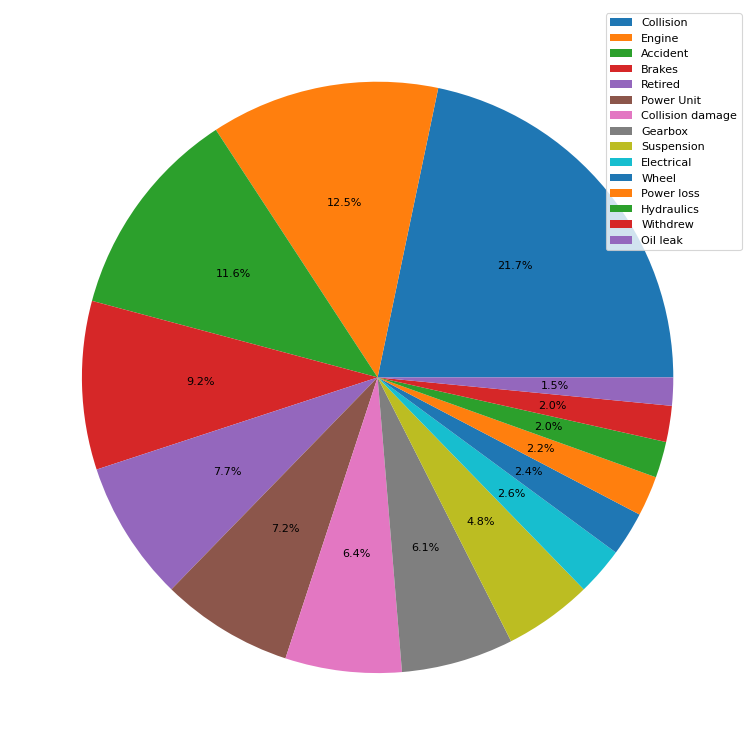

In [35]:
top_incidents = incidents[:15]

fig, axs = plt.subplots(1, dpi=80)
fig.set_size_inches(15, 12)

axs.set_title('')
axs.pie(top_incidents.values, autopct='%1.1f%%')
axs.legend(top_incidents.index, loc=1)
plt.plot()

In [36]:
def format_status(x):
    incident_dict = {
        'Mechanical Failure': ['Differential','Fuel pump','Water pump','Cooling system','Radiator', 'Spark plugs', 'Steering', 'Out of fuel', 'Seat', 'Vibrations','Brake duct','Drivetrain','Fuel system','Technical','Clutch', 'Water leak', 'ERS', 'Battery', 'Tyre', 'Oil pressure', 'Throttle', 'Retired', 'Gearbox', 'Exhaust','Suspension', 'Electronics', 'Wheel', 'Fuel pressure', 'Brakes', 'Engine', 'Overheating', 'Power Unit', 'Mechanical', 'Power loss', 'Water pressure', 'Driveshaft', 'Transmission', 'Electrical', 'Wheel nut', 'Turbo', 'Hydraulics', 'Oil leak'],
        'Collision': ['Fuel leak','Undertray', 'Spun off', 'Front wing', 'Collision damage', 'Accident', 'Collision', 'Debris', 'Puncture', 'Damage', 'Rear wing'],
        'Other': ['Illness', 'Withdrew', 'Disqualified', 'Excluded']
    }
    for col in incident_dict:
        if x in incident_dict[col]:
            return col
    
    return x

In [37]:
data['actual'] = data.status.apply(lambda x: format_status(x))

data.head()

,season,round,circuit_id,driver,date_of_birth,nationality,constructor,grid,time,status,points,podium,fastest_lap,actual
0,2014,1,albert_park,rosberg,1985-06-27,German,mercedes,3,5578710.0,Finished,25.0,1,1:32.478,Finished
1,2014,1,albert_park,kevin_magnussen,1992-10-05,Danish,mclaren,4,5605487.0,Finished,18.0,2,1:33.066,Finished
2,2014,1,albert_park,button,1980-01-19,British,mclaren,10,5608737.0,Finished,15.0,3,1:32.917,Finished
3,2014,1,albert_park,alonso,1981-07-29,Spanish,ferrari,5,5613994.0,Finished,12.0,4,1:33.186,Finished
4,2014,1,albert_park,bottas,1989-08-28,Finnish,williams,15,5626349.0,Finished,10.0,5,1:32.616,Finished


In [38]:
# incidents = data.query(
#     'actual != "Finished"'
# ).actual.value_counts()

### Only car statuses that did not finish race are included
finished = data[data.actual.str.contains('Finished|Lap')]
dnfs = data[~data.actual.str.contains('Lap|Finished')]

incidents = dnfs.actual.value_counts()

In [39]:
print('Percentage of drivers who DNF a race: {:.2f}%'.format(len(dnfs)/(len(finished)+len(dnfs)) * 100))

Percentage of drivers who DNF a race: 19.38%


[]

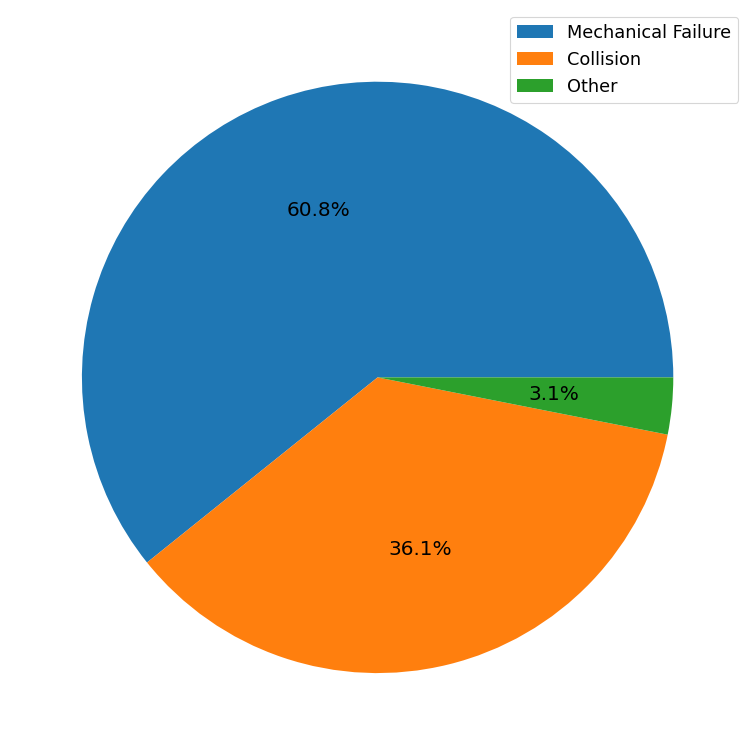

In [40]:
fig, axs = plt.subplots(1, dpi=80)
fig.set_size_inches(15, 12)

axs.set_title('')
axs.pie(incidents.values, autopct='%1.1f%%', textprops={'fontsize': 18})
axs.legend(incidents.index, loc=1, prop={'size': 16})
plt.plot()

In [114]:
race_counts = data.groupby(['season', 'circuit_id']).agg({
    'round': 'nunique'
}).reset_index().groupby('circuit_id').agg({'round': 'sum'}).reset_index()

dnfs_by_circuit = dnfs.groupby('circuit_id').agg({
    'actual': 'count'
    }).reset_index()

dnfs_by_circuit
race_counts

df = pd.merge(dnfs_by_circuit, race_counts, how='inner', on=['circuit_id'])
df.rename(columns = {'actual': 'dnfs', 'round': 'race_count'}, inplace=True)

In [125]:
def calculate_dnf_per_race(row):
    return round(row.dnfs / row.race_count, 2)

In [147]:
df['dnf_per_race'] = df.apply(lambda row: calculate_dnf_per_race(row), axis=1)

average_dnfs_circuits = df.query('race_count > 1').sort_values('dnf_per_race')

In [136]:
### Finding any missing circuit_ids

set(list(data.circuit_id.values)) - set(list(dnfs_by_circuit.circuit_id.values))

set()

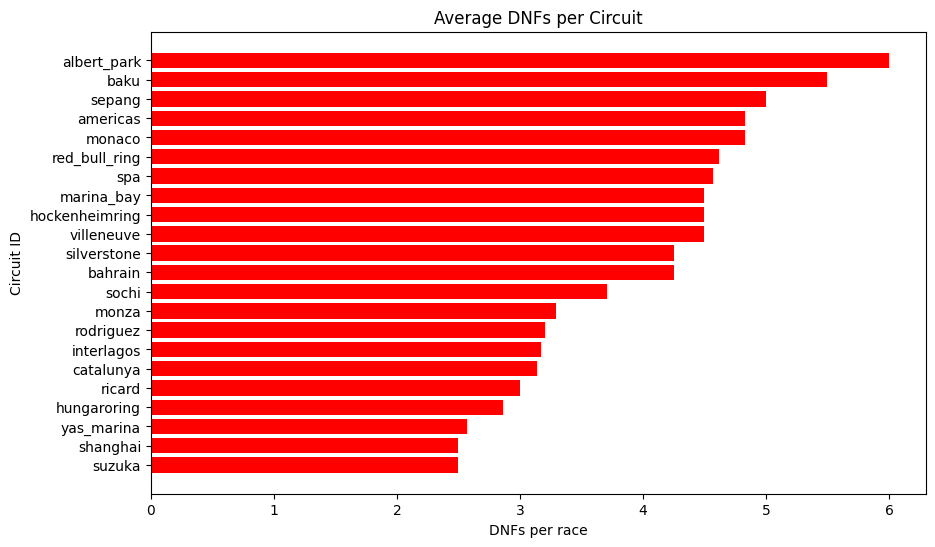

In [148]:
fig, axs = plt.subplots(1, dpi=100)
fig.set_size_inches(10,6)

axs.set_title('Average DNFs per Circuit')
axs.set_xlabel('DNFs per race')
axs.set_ylabel('Circuit ID')
axs.barh(average_dnfs_circuits.circuit_id, average_dnfs_circuits.dnf_per_race, color='r')
plt.show()